In [1]:
#Read training data
import pandas as pd
fileName = "trainData.csv"
df = pd.read_csv(fileName, sep = ',')

In [2]:
df.head()

,ID,O,C,H,L,V,BV,Mean,T,MarketName,Reward
0,1,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878,-0.008966,2015-12-15,BTC-ETH,-0.896561
1,1,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358,0.005236,2015-12-16,BTC-ETH,0.523557
2,1,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502,-0.064499,2015-12-17,BTC-ETH,-6.449900
3,1,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244,-0.038707,2015-12-18,BTC-ETH,-3.870695
4,1,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657,-0.031732,2015-12-19,BTC-ETH,-3.173201


In [3]:
colnames = ['T','O','C','H','L','V','BV']
reward_cols = ['T','Reward']

In [4]:
eth = df[(df['MarketName'] == 'BTC-ETH')][colnames]
xrp = df[(df['MarketName'] == 'BTC-XRP')][colnames]
ltc = df[(df['MarketName'] == 'BTC-LTC')][colnames]
xlm = df[(df['MarketName'] == 'BTC-XLM')][colnames]
usd = df[(df['MarketName'] == 'USDT-BTC')][colnames]

In [5]:
eth.head()

,T,O,C,H,L,V,BV
0,2015-12-15,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878
1,2015-12-16,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358
2,2015-12-17,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502
3,2015-12-18,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244
4,2015-12-19,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657


In [6]:
eth_reward = df[(df['MarketName'] == 'BTC-ETH')][reward_cols]
xrp_reward = df[(df['MarketName'] == 'BTC-XRP')][reward_cols]
ltc_reward = df[(df['MarketName'] == 'BTC-LTC')][reward_cols]
xlm_reward = df[(df['MarketName'] == 'BTC-XLM')][reward_cols]
usd_reward = df[(df['MarketName'] == 'USDT-BTC')][reward_cols]
usd_reward.loc[:,'Reward'] *= -1 # Because we used tether reward

In [7]:
eth_reward.head()

,T,Reward
0,2015-12-15,-0.896561
1,2015-12-16,0.523557
2,2015-12-17,-6.449900
3,2015-12-18,-3.870695
4,2015-12-19,-3.173201


In [8]:
merged1 = pd.merge(eth, xrp, on = 'T', suffixes=('_eth', '_xrp'))
merged2 = pd.merge(ltc, xlm, on = 'T', suffixes=('_ltc', '_xlm'))
merged = pd.merge(merged1, merged2, on = 'T')
merged = pd.merge(merged, usd, on = 'T')
merged.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,...,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
0,2015-12-15,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878,-0.250256,-0.100416,-0.212046,...,-0.043933,-0.144351,1029.180334,885.502597,0.000000,0.071429,0.071429,0.000000,1320.637261,1410.396749
1,2015-12-16,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358,-0.111491,0.131640,-0.027795,...,-0.052516,0.000000,-0.521941,-0.507073,0.071429,0.002222,0.044444,0.071429,-0.815032,-0.810448
2,2015-12-17,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502,0.131640,-0.024490,-0.025341,...,-0.055427,0.000000,-0.992587,-0.992851,0.071429,0.002222,0.044444,0.071429,-0.815032,-0.810448
3,2015-12-18,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244,-0.040816,-0.056485,-0.054000,...,0.058680,0.019560,1.314162,1.401100,0.020000,0.017738,-0.023404,0.020000,-0.999841,-0.999841
4,2015-12-19,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657,-0.036879,-0.002956,-0.038055,...,-0.053118,-0.098321,11.826813,10.635375,-0.017429,-0.017429,-0.017429,-0.017429,863.027096,847.967800


# KNN SETTINGS

In [9]:
import random
import numpy as np
from collections import deque
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.preprocessing import MinMaxScaler
from random import randint

In [10]:
class TradingAction(object):
    ETH = 0
    XRP = 1
    LTC = 2
    XLM = 3
    USD = 4
    BTC = 5
    
class TradingEnv:
  def __init__(self):
    #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
    pass

  def reset(self):
    pass

  def __init__(self):
    #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
    pass

  def step(self, action, date):
    reward = 0
    if action == TradingAction.ETH:
        reward = eth_reward[(eth_reward['T'] == date)]['Reward']
    if action == TradingAction.XRP:
        reward = xrp_reward[(xrp_reward['T'] == date)]['Reward']
    if action == TradingAction.LTC:
        reward = ltc_reward[(ltc_reward['T'] == date)]['Reward']
    if action == TradingAction.XLM:
        reward = xlm_reward[(xlm_reward['T'] == date)]['Reward']
    if action == TradingAction.USD:
        reward = usd_reward[(usd_reward['T'] == date)]['Reward']
    if action == TradingAction.BTC:
        reward = 0 # Do nothing action
    return reward

In [67]:
#Split as Train and Test data
row_count = merged.shape[0]
split_point = int(row_count - 60)
train_data, test_data = merged[:split_point], merged[split_point:]
test_data.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,...,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
1190,2019-03-19,-0.008638,-0.000860,-0.010302,0.000862,-0.242948,-0.247808,-0.005050,-0.002156,-0.006422,...,-0.001681,0.034431,-0.426080,-0.424562,0.001601,0.004968,0.000365,0.003223,-0.426543,-0.424743
1191,2019-03-20,-0.000039,-0.003951,-0.008330,-0.008638,-0.063724,-0.068058,-0.001903,-0.001144,0.012546,...,-0.053872,-0.028582,-0.321484,-0.342432,0.006122,0.007443,0.003994,0.003877,0.153287,0.159204
1192,2019-03-21,-0.004292,-0.015139,-0.002748,-0.011451,0.323505,0.315041,-0.000890,-0.010308,-0.013517,...,-0.032028,-0.051024,-0.022323,-0.063149,0.006040,-0.015198,0.002972,-0.018895,0.765888,0.755553
1193,2019-03-22,-0.014801,0.007919,-0.004498,-0.000200,-0.207166,-0.209078,-0.010434,0.000000,-0.008627,...,0.009926,0.029042,-0.383236,-0.371657,-0.014622,0.001982,-0.013914,0.014609,-0.455185,-0.455566
1194,2019-03-23,0.007276,0.003864,0.004777,0.009597,-0.236036,-0.232347,0.000129,0.000386,0.000256,...,-0.005825,0.011060,-0.086430,-0.088340,0.002648,0.003766,0.004866,0.001829,-0.350675,-0.349206


In [68]:
#Preprocess Data
scaler = MinMaxScaler()
scaled_cols = ['O_eth','C_eth','H_eth','L_eth','V_eth','BV_eth','O_xrp','C_xrp','H_xrp','L_xrp','V_xrp','BV_xrp','O_ltc','C_ltc','H_ltc','L_ltc','V_ltc','BV_ltc','O_xlm','C_xlm','H_xlm','L_xlm','V_xlm','BV_xlm','O','C','H','L','V','BV']
scaler.fit(train_data[scaled_cols])
train_data.iloc[:][scaled_cols] = scaler.transform(train_data[scaled_cols])
#Use same scaler to transform test data
test_data.iloc[:][scaled_cols] = scaler.transform(test_data[scaled_cols])

In [69]:
train_data.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,...,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
0,2015-12-15,0.442294,0.378528,0.364552,0.428364,0.052847,0.053281,0.109463,0.175298,0.049073,...,0.134094,0.002061,4.322030e-02,3.154945e-02,0.412240,0.570424,0.638054,0.409259,9.796437e-03,9.717054e-03
1,2015-12-16,0.362899,0.415824,0.423727,0.404799,0.056164,0.056314,0.170113,0.277759,0.116677,...,0.130595,0.002409,2.001161e-05,1.750484e-05,0.569013,0.418152,0.571256,0.496974,1.371000e-06,1.304971e-06
2,2015-12-17,0.442582,0.316062,0.258978,0.383128,0.019742,0.018800,0.276379,0.208822,0.117578,...,0.129408,0.002409,2.660729e-07,2.166164e-07,0.569013,0.418152,0.571256,0.496974,1.371000e-06,1.304971e-06
3,2015-12-18,0.321294,0.349746,0.272538,0.444088,0.019224,0.018233,0.201003,0.194695,0.107062,...,0.175928,0.002457,9.704375e-05,8.541427e-05,0.456136,0.452291,0.403299,0.433819,1.135148e-09,1.054243e-09
4,2015-12-19,0.354857,0.399185,0.325240,0.404743,0.040113,0.040105,0.202724,0.218330,0.112913,...,0.130349,0.002172,5.380931e-04,4.140502e-04,0.373986,0.374913,0.418090,0.387856,6.404471e-03,5.844895e-03


In [70]:
#Action selection
def select_act(env, date):
    r0 = env.step(0, date)
    r1 = env.step(1, date)
    r2 = env.step(2, date)
    r3 = env.step(3, date)
    r4 = env.step(4, date)
    r5 = env.step(5, date)
    rewards = np.asarray([r0.item(),r1.item(),r2.item(),r3.item(),r4.item(),r5])
    return rewards
    

In [71]:
#KNN
observation_cols = ['O_eth','C_eth','H_eth','L_eth','V_eth','BV_eth','O_xrp','C_xrp','H_xrp','L_xrp','V_xrp','BV_xrp','O_ltc','C_ltc','H_ltc','L_ltc','V_ltc','BV_ltc','O_xlm','C_xlm','H_xlm','L_xlm','V_xlm','BV_xlm','O','C','H','L','V','BV']
state_size = len(observation_cols)
action_size = 6 #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
env = TradingEnv()

test_reward = 0
reward_list = []
for idx in range(len(test_data)-1):
    state = test_data.iloc[idx][observation_cols]
    #state = np.reshape([state], [1, state_size])
    
    distances = manhattan_distances(train_data[observation_cols], [state])
    most_similar_index = distances.argmin()
    date = train_data.iloc[most_similar_index]['T']
    act_vals = select_act(env, date)
    action = np.argmax(act_vals)
    reward = env.step(action, test_data.iloc[idx+1]['T'])
    if isinstance(reward, int) == False:
        reward = reward.item()
    test_reward = test_reward + reward 
    reward_list.append(reward)
print("Test_reward: {}" .format(test_reward))

Test_reward: -9.047929973126873


In [74]:
#We get most similar neighbours with 10% error rate
mscaler = MinMaxScaler()

test_reward = 0
pred_reward = 0
reward_list = []
for idx in range(len(test_data)-1):
    state = test_data.iloc[idx][observation_cols]
    #state = np.reshape([state], [1, state_size])
    
    distances = manhattan_distances(train_data[observation_cols], [state])
    distances = mscaler.fit_transform(distances)
    most_similar_index = distances.argmin()
    mask = (distances[most_similar_index] + 0.1 > distances)
    dates = train_data[mask]['T']
    total_array = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0])
    for date in dates:
        act_vals = select_act(env, date)
        total_array += act_vals
    total_array /= len(dates)
    pred_r = np.max(total_array)
    action = np.argmax(total_array)
    reward = env.step(action, test_data.iloc[idx+1]['T'])
    if isinstance(reward, int) == False:
        reward = reward.item()
    test_reward = test_reward + reward 
    reward_list.append(reward)
    pred_reward += pred_r
print("Test_reward: {}, Expected_reward: {}" .format(test_reward, pred_reward))

Test_reward: 23.249250329218004, Expected_reward: 25.126504401860668


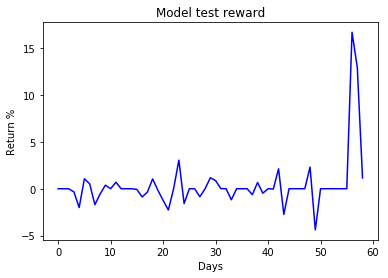

In [75]:
#Plot rewards
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(0,len(test_data)-1,1),reward_list, c='b')
plt.title('Model test reward')
plt.ylabel('Return %')
plt.xlabel('Days')
plt.show()

In [76]:
index = -1
print(merged.iloc[index]['T'])
state = merged.iloc[index][observation_cols]
distances = manhattan_distances(train_data[observation_cols], [state])
most_similar_index = distances.argmin()
date = train_data.iloc[most_similar_index]['T']
act_vals = select_act(env, date)
action = np.argmax(act_vals)
print("Predicted rewards",act_vals)
print("Best action",action)
#Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc

2019-05-17
Predicted rewards [ -5.63814251 -16.8706056   -6.9582362  -20.59698322  16.4479749
   0.        ]
Best action 4


In [61]:
index = -6
print(merged.iloc[index]['T'])
state = merged.iloc[index][observation_cols]
distances = manhattan_distances(train_data[observation_cols], [state])

distances = mscaler.fit_transform(distances)
most_similar_index = distances.argmin()
mask = (distances[most_similar_index] + 0.05 > distances)
dates = train_data[mask]['T']
total_array = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0])
for date in dates:
    act_vals = select_act(env, date)
    total_array += act_vals
total_array /= len(dates)
pred_r = np.max(total_array)
action = np.argmax(total_array)
print("Predicted rewards",total_array)
print("Predicted best reward",pred_r)
print("Best action",action)
#Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc

2019-05-12
Predicted rewards [-7.37389152 -5.79850015 -4.66343587 -9.05990669  9.60179492  0.        ]
Predicted best reward 9.60179491655742
Best action 4


In [55]:
index = -5
print(eth_reward.iloc[index]['T'])
r1 = eth_reward.iloc[index]['Reward'].item()
r2 = xrp_reward.iloc[index]['Reward'].item()
r3 = ltc_reward.iloc[index]['Reward'].item()
r4 = xlm_reward.iloc[index]['Reward'].item()
r5 = usd_reward.iloc[index]['Reward'].item()
print("eth: {}, xrp: {}, ltc: {}, xlm: {}, usd: {}, btc: {}" .format(r1, r2, r3, r4, r5, 0))

2019-05-13
eth: -3.07079807693027, xrp: -1.17298713130621, ltc: -2.05560936161441, xlm: -3.8831492696829395, usd: -4.81129072663069, btc: 0
